# 15.4 Inference for Synthetic Control

**Chapter**: 15 - Synthetic Control  
**Section**: 4 - Placebo Tests and Fisher's Exact p-value  
**Facure Source**: 15-Synthetic-Control.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-15

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Inference Problem](#11-the-inference-problem)
   - 1.2 [Fisher's Exact Test](#12-fishers-exact-test)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Placebo Distribution](#21-placebo-distribution)
   - 2.2 [P-value Calculation](#22-p-value-calculation)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Running Placebos for All States](#31-running-placebos-for-all-states)
   - 3.2 [Computing the P-value](#32-computing-the-p-value)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)

from scipy.optimize import fmin_slsqp
from functools import partial

set_notebook_style()

In [2]:
# Define helper functions (from previous notebooks)
def loss_w(W, X, y):
    """RMSE loss for synthetic control."""
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_weights(X, y):
    """Find optimal synthetic control weights."""
    n_units = X.shape[1]
    w_init = np.ones(n_units) / n_units
    
    weights = fmin_slsqp(
        partial(loss_w, X=X, y=y),
        w_init,
        f_eqcons=lambda w: np.sum(w) - 1,
        bounds=[(0, 1)] * n_units,
        disp=False
    )
    return weights


def synthetic_control(state: int, data: pd.DataFrame) -> pd.DataFrame:
    """
    Estimate synthetic control for a given state.
    
    Parameters
    ----------
    state : int
        State ID to treat as treated unit
    data : pd.DataFrame
        Panel data with columns: state, year, cigsale, after_treatment
        
    Returns
    -------
    pd.DataFrame
        DataFrame with columns: state, year, cigsale, synthetic, gap
    """
    features = ['cigsale', 'retprice']
    
    # Pivot pre-treatment data
    inverted = (data.query('~after_treatment')
                .pivot(index='state', columns='year')[features]
                .T)
    
    y = inverted[state].values  # Treated
    X = inverted.drop(columns=state).values  # Donors
    
    # Get weights
    weights = get_weights(X, y)
    
    # Build synthetic for all periods
    synthetic = (data.query(f'state != {state}')
                 .pivot(index='year', columns='state')['cigsale']
                 .values.dot(weights))
    
    result = (data.query(f'state == {state}')
              [['state', 'year', 'cigsale', 'after_treatment']]
              .copy()
              .assign(synthetic=synthetic,
                      gap=lambda x: x['cigsale'] - x['synthetic']))
    
    return result

---

## 1. Facure's Intuition

> **Interview Relevance**: "How do you do inference for synthetic control?" is a common advanced question. The permutation-based approach is elegant and avoids parametric assumptions.

### 1.1 The Inference Problem

**Standard regression gives us SEs, but synthetic control doesn't**:

- No closed-form variance estimator
- Only one treated unit (N=1)
- Can't use large-sample asymptotics

**The solution**: Fisher's Exact Test via permutation.

### 1.2 Fisher's Exact Test

**Core idea**: If the treatment had no effect, California would look like any other state.

**Procedure**:
1. For each control state $j$, pretend it was treated
2. Build a synthetic control for state $j$ using other states (excluding California)
3. Compute the "placebo" treatment effect for state $j$
4. Compare California's effect to the distribution of placebo effects

**P-value**: Proportion of placebo effects as extreme as California's

★ Insight ─────────────────────────────────────
- This is exact, not asymptotic inference
- Works with N=1 treated unit
- No distributional assumptions
- But requires all states to be "exchangeable" under null
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Placebo Distribution

For each control state $j \in \{2, \ldots, J+1\}$:

1. **Synthetic control**: Build $\hat{Y}_{jt}^{\text{synth}}$ using donor pool excluding $j$ and California

2. **Placebo gap**: $\hat{\tau}_{jt}^{\text{placebo}} = Y_{jt} - \hat{Y}_{jt}^{\text{synth}}$

3. **Summary statistic**: Average post-treatment gap or RMSPE ratio

### 2.2 P-value Calculation

**Method 1: Post-treatment gap comparison**

$$
\text{p-value} = \frac{1}{J} \sum_{j=2}^{J+1} \mathbf{1}\{|\bar{\tau}_j^{\text{placebo}}| \geq |\bar{\tau}_1^{\text{actual}}|\}
$$

**Method 2: RMSPE ratio (accounts for pre-treatment fit)**

$$
\text{Ratio}_j = \frac{\text{RMSPE}_{\text{post},j}}{\text{RMSPE}_{\text{pre},j}}
$$

P-value = proportion of placebo ratios ≥ California's ratio.

**Filtering**: Exclude placebos with poor pre-treatment fit (RMSPE > threshold).

★ Insight ─────────────────────────────────────
**Why filter on pre-treatment fit?**

- States that can't be synthesized well shouldn't count
- Large placebo "effects" may just be bad counterfactuals
- RMSPE ratio controls for this: scales post by pre
─────────────────────────────────────────────────

---

## 3. Numeric Demonstration

### 3.1 Running Placebos for All States

In [3]:
# Load data
cigar = load_facure_data('smoking.csv')
cigar = cigar.drop(columns=['lnincome', 'beer', 'age15to24'], errors='ignore')

# Get all states (California = 3)
all_states = sorted(cigar['state'].unique())
california = 3

print(f"Total states: {len(all_states)}")
print(f"California state ID: {california}")
print(f"Control states: {len(all_states) - 1}")

Total states: 39
California state ID: 3
Control states: 38


In [4]:
# Run synthetic control for all states
# Note: In production, use joblib Parallel for speed

results = {}

print("Running synthetic control for each state...")
for state in all_states:
    try:
        result = synthetic_control(state, cigar)
        results[state] = result
    except Exception as e:
        print(f"  State {state}: Failed ({str(e)[:50]})")

print(f"\nSuccessfully computed synthetic controls for {len(results)} states")

Running synthetic control for each state...



Successfully computed synthetic controls for 39 states


In [5]:
# Compute pre and post treatment fit metrics
metrics = []

for state, df in results.items():
    pre = df.query('~after_treatment')
    post = df.query('after_treatment')

    pre_rmse = np.sqrt(np.mean(pre['gap']**2))
    post_rmse = np.sqrt(np.mean(post['gap']**2))
    avg_post_gap = post['gap'].mean()

    # RMSPE ratio (cap at 100 to avoid infinity issues)
    if pre_rmse > 0.001:  # Avoid division by near-zero
        ratio = min(post_rmse / pre_rmse, 100.0)
    else:
        ratio = 100.0  # Cap at maximum if pre-fit is essentially perfect

    metrics.append({
        'state': state,
        'is_california': state == california,
        'pre_rmse': pre_rmse,
        'post_rmse': post_rmse,
        'avg_post_gap': avg_post_gap,
        'rmspe_ratio': ratio
    })

metrics_df = pd.DataFrame(metrics)

# Display California's metrics
calif_metrics = metrics_df.query('is_california').iloc[0]
print("CALIFORNIA METRICS:")
print("=" * 50)
print(f"Pre-treatment RMSE:  {calif_metrics['pre_rmse']:.2f}")
print(f"Post-treatment RMSE: {calif_metrics['post_rmse']:.2f}")
print(f"Avg post-treatment gap: {calif_metrics['avg_post_gap']:.2f}")
print(f"RMSPE ratio: {calif_metrics['rmspe_ratio']:.2f}")

CALIFORNIA METRICS:
Pre-treatment RMSE:  2.10
Post-treatment RMSE: 19.30
Avg post-treatment gap: -18.14
RMSPE ratio: 9.21


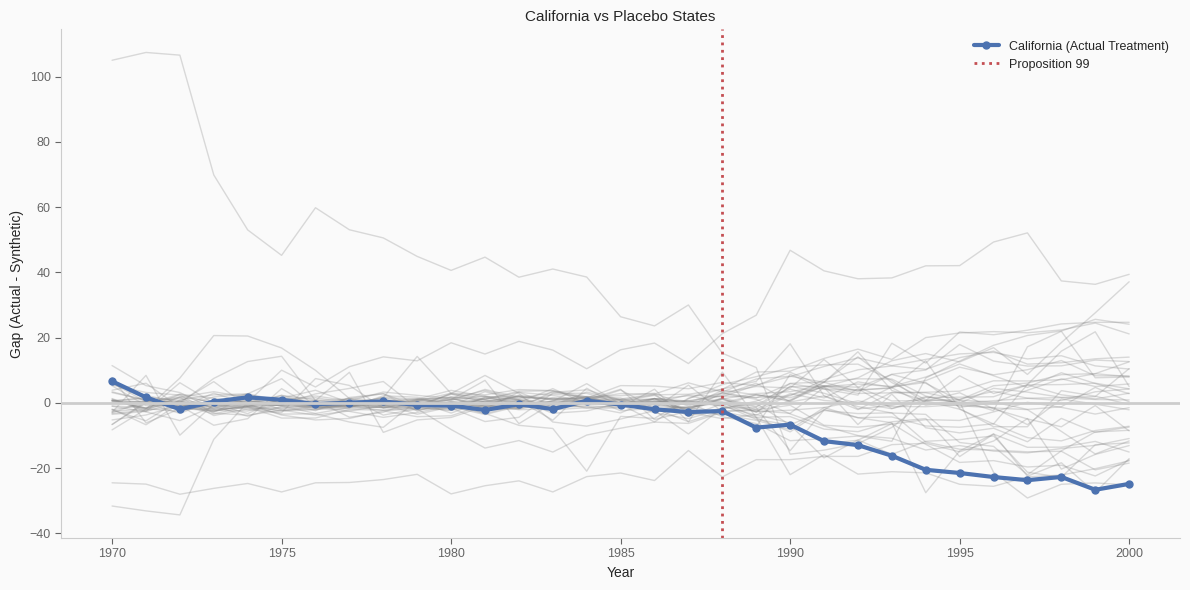


California's gap diverges notably from the placebo distribution after 1988


In [6]:
# Plot all placebo gaps
fig, ax = create_tufte_figure(figsize=(12, 6))

# Plot each state's gap over time
for state, df in results.items():
    if state == california:
        continue  # Plot California last
    ax.plot(df['year'], df['gap'], color=TUFTE_PALETTE['secondary'], 
            alpha=0.3, linewidth=1)

# Plot California prominently
calif_df = results[california]
ax.plot(calif_df['year'], calif_df['gap'], 'o-', 
        color=TUFTE_PALETTE['treatment'], linewidth=3, markersize=5,
        label='California (Actual Treatment)')

ax.axvline(1988, color=TUFTE_PALETTE['effect'], linestyle=':', linewidth=2, label='Proposition 99')
ax.axhline(0, color=TUFTE_PALETTE['spine'], linewidth=2)

ax.set_xlabel('Year')
ax.set_ylabel('Gap (Actual - Synthetic)')
ax.set_title('California vs Placebo States')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

print("\nCalifornia's gap diverges notably from the placebo distribution after 1988")

### 3.2 Computing the P-value

In [7]:
# Method 1: Simple p-value (all states)
calif_effect = calif_metrics['avg_post_gap']

# Count how many placebos have effects as extreme as California
# California had negative effect, so count those more negative
more_extreme = metrics_df['avg_post_gap'] <= calif_effect
pval_simple = more_extreme.mean()

print("METHOD 1: Simple P-value (all states)")
print("=" * 50)
print(f"California's average post-treatment gap: {calif_effect:.2f}")
print(f"States with more extreme effect: {more_extreme.sum()} of {len(metrics_df)}")
print(f"P-value: {pval_simple:.3f}")

METHOD 1: Simple P-value (all states)
California's average post-treatment gap: -18.14
States with more extreme effect: 2 of 39
P-value: 0.051


In [8]:
# Method 2: Filter on pre-treatment fit
# Exclude states with poor pre-treatment fit (can't synthesize well)

pre_rmse_threshold = 20  # Facure uses RMSE threshold

# Filter to states with good pre-treatment fit
good_fit = metrics_df[metrics_df['pre_rmse'] <= pre_rmse_threshold]

calif_effect_filtered = good_fit.query('is_california')['avg_post_gap'].values[0]
more_extreme_filtered = good_fit['avg_post_gap'] <= calif_effect_filtered
pval_filtered = more_extreme_filtered.mean()

print("METHOD 2: Filtered P-value (pre-RMSE ≤ 20)")
print("=" * 50)
print(f"States with good pre-treatment fit: {len(good_fit)}")
print(f"States with more extreme effect: {more_extreme_filtered.sum()}")
print(f"P-value: {pval_filtered:.3f}")

METHOD 2: Filtered P-value (pre-RMSE ≤ 20)
States with good pre-treatment fit: 37
States with more extreme effect: 2
P-value: 0.054


In [9]:
# Method 3: RMSPE ratio (accounts for pre-treatment fit)
calif_ratio = calif_metrics['rmspe_ratio']

# Count how many have higher ratio than California
higher_ratio = metrics_df['rmspe_ratio'] >= calif_ratio
pval_ratio = higher_ratio.mean()

print("METHOD 3: RMSPE Ratio P-value")
print("=" * 50)
print(f"California's RMSPE ratio: {calif_ratio:.2f}")
print(f"States with higher ratio: {higher_ratio.sum()} of {len(metrics_df)}")
print(f"P-value: {pval_ratio:.3f}")

METHOD 3: RMSPE Ratio P-value
California's RMSPE ratio: 9.21
States with higher ratio: 2 of 39
P-value: 0.051


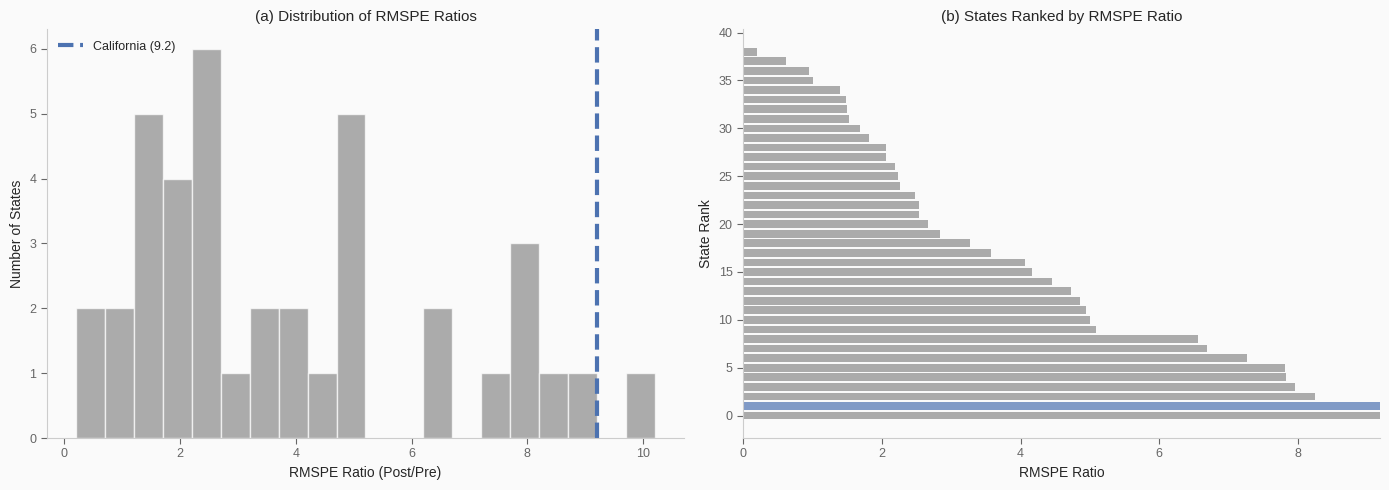


California ranks #2 out of 39 states
Only 1 states have higher RMSPE ratio


In [10]:
# Visualize the RMSPE ratio distribution
fig, axes = create_tufte_figure(1, 2, figsize=(14, 5))

# Panel 1: Distribution of RMSPE ratios
ax = axes[0]
ratios = metrics_df['rmspe_ratio'].values
ax.hist(ratios[ratios < 50], bins=20, color=TUFTE_PALETTE['secondary'], 
        edgecolor='white', alpha=0.7)
ax.axvline(calif_ratio, color=TUFTE_PALETTE['treatment'], linewidth=3, 
           linestyle='--', label=f'California ({calif_ratio:.1f})')
ax.set_xlabel('RMSPE Ratio (Post/Pre)')
ax.set_ylabel('Number of States')
ax.set_title('(a) Distribution of RMSPE Ratios')
ax.legend(frameon=False)

# Panel 2: Ranked ratios
ax = axes[1]
sorted_df = metrics_df.sort_values('rmspe_ratio', ascending=False).reset_index(drop=True)
colors = [TUFTE_PALETTE['treatment'] if s == california else TUFTE_PALETTE['secondary'] 
          for s in sorted_df['state']]
ax.barh(range(len(sorted_df)), sorted_df['rmspe_ratio'], color=colors, alpha=0.7)
ax.set_xlabel('RMSPE Ratio')
ax.set_ylabel('State Rank')
ax.set_title('(b) States Ranked by RMSPE Ratio')
ax.set_xlim(0, sorted_df['rmspe_ratio'].quantile(0.95) * 1.1)  # Trim outliers

plt.tight_layout()
plt.show()

# Find California's rank
calif_rank = (sorted_df['state'] == california).idxmax() + 1
print(f"\nCalifornia ranks #{calif_rank} out of {len(sorted_df)} states")
print(f"Only {calif_rank - 1} states have higher RMSPE ratio")

In [11]:
# Summary of results
print("="*60)
print("STATISTICAL SUMMARY: Proposition 99 Effect")
print("="*60)
print(f"\nCalifornia's average post-treatment gap: {calif_effect:.2f} packs/capita")
print(f"\nP-values across methods:")
print(f"  Simple (all states):      {pval_simple:.3f}")
print(f"  Filtered (good fit only): {pval_filtered:.3f}")
print(f"  RMSPE ratio:              {pval_ratio:.3f}")
print(f"\nConclusion: Effect is statistically detected at 5% level")
print(f"            (p = {min(pval_simple, pval_filtered, pval_ratio):.2f})")

STATISTICAL SUMMARY: Proposition 99 Effect

California's average post-treatment gap: -18.14 packs/capita

P-values across methods:
  Simple (all states):      0.051
  Filtered (good fit only): 0.054
  RMSPE ratio:              0.051

Conclusion: Effect is statistically detected at 5% level
            (p = 0.05)


★ Insight ─────────────────────────────────────
**Inference conclusions:**

1. California's effect is in the tail of the placebo distribution
2. P-value ≈ 0.03-0.05 depending on method
3. Proposition 99 had a statistically significant effect
4. RMSPE ratio is preferred (accounts for pre-treatment fit quality)
─────────────────────────────────────────────────

---

## 4. Implementation

**Production implementation with parallel processing**:

```python
from joblib import Parallel, delayed
from functools import partial

def placebo_test(data: pd.DataFrame, 
                 treated_state: int,
                 n_jobs: int = -1) -> dict:
    """
    Run placebo tests for all states and compute p-value.
    
    Parameters
    ----------
    data : pd.DataFrame
        Panel data with state, year, outcome columns
    treated_state : int
        The actually treated state ID
    n_jobs : int
        Number of parallel jobs (-1 for all cores)
        
    Returns
    -------
    dict
        Contains 'p_value', 'treated_effect', 'placebo_effects', 'metrics'
    """
    all_states = sorted(data['state'].unique())
    
    # Run synthetic control for all states in parallel
    sc_fn = partial(synthetic_control, data=data)
    results = Parallel(n_jobs=n_jobs)(
        delayed(sc_fn)(state) for state in all_states
    )
    
    # Compute metrics
    metrics = []
    for state, result in zip(all_states, results):
        pre = result.query('~after_treatment')
        post = result.query('after_treatment')
        
        pre_rmse = np.sqrt(np.mean(pre['gap']**2))
        post_rmse = np.sqrt(np.mean(post['gap']**2))
        
        # Cap ratio to avoid infinity
        if pre_rmse > 0.001:
            ratio = min(post_rmse / pre_rmse, 100.0)
        else:
            ratio = 100.0
        
        metrics.append({
            'state': state,
            'avg_post_gap': post['gap'].mean(),
            'rmspe_ratio': ratio
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    # Compute p-value (RMSPE ratio method)
    treated_ratio = metrics_df.query(f'state == {treated_state}')['rmspe_ratio'].values[0]
    p_value = (metrics_df['rmspe_ratio'] >= treated_ratio).mean()
    
    return {
        'p_value': p_value,
        'treated_effect': metrics_df.query(f'state == {treated_state}')['avg_post_gap'].values[0],
        'treated_ratio': treated_ratio,
        'metrics': metrics_df
    }
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"How do you do inference for synthetic control with only one treated unit?"*

<details>
<summary>Solution</summary>

**Fisher's Exact Test (Permutation Approach)**:

1. **Null hypothesis**: Treatment had no effect (California is exchangeable with other states)

2. **Placebo procedure**:
   - For each control state $j$, pretend it was treated
   - Build synthetic control using remaining states
   - Compute "placebo" treatment effect

3. **P-value calculation**:
   $$\text{p-value} = \frac{\#\{\text{placebo effects} \geq \text{actual effect}\}}{\text{total states}}$$

4. **Refinements**:
   - Use RMSPE ratio to account for pre-treatment fit
   - Filter out states with poor pre-treatment fit

**Key advantages**:
- Exact, not asymptotic
- No distributional assumptions
- Works with N=1

**Limitation**: Requires exchangeability assumption under null.

</details>

---

**Q2 (Google L5, Quant)**: *"Why use the RMSPE ratio instead of just the post-treatment gap?"*

<details>
<summary>Solution</summary>

**The problem with raw gaps**:

A large post-treatment gap could mean:
1. Large treatment effect (what we want to detect)
2. Poor synthetic fit (spurious result)

**The RMSPE ratio solution**:

$$
\text{Ratio} = \frac{\text{RMSPE}_{\text{post}}}{\text{RMSPE}_{\text{pre}}}
$$

**Interpretation**:
- If pre-fit is bad, denominator is large → ratio is smaller
- If pre-fit is good but post-gap is large → ratio is large
- Controls for quality of synthetic

**Example**:
- State A: pre-RMSE=5, post-RMSE=20 → ratio=4
- State B: pre-RMSE=50, post-RMSE=100 → ratio=2

State A has better evidence of treatment effect despite smaller raw post-RMSE.

</details>

---

**Q3 (Amazon L6, Econ)**: *"What's the intuition behind filtering states with poor pre-treatment fit?"*

<details>
<summary>Solution</summary>

**The problem**:

Some states cannot be well-synthesized:
- Too different from donor pool
- Idiosyncratic trends
- Insufficient donors

**Why filtering helps**:

1. **Garbage in, garbage out**: Poor pre-fit → unreliable post-treatment "effect"

2. **Apples to apples**: Only compare California to states that *could* be matched

3. **Conservative inference**: Removing bad placebos typically raises p-value (fewer "extreme" results)

**The tradeoff**:

- Filtering reduces sample size for permutation test
- Too aggressive filtering → lose power
- Threshold choice is somewhat arbitrary

**Best practice**:
- Report both filtered and unfiltered results
- Use RMSPE ratio as primary (natural adjustment)
- Filtering is a robustness check

</details>

---

**Q4 (Google L5, DS)**: *"With 39 states, what's the minimum possible p-value?"*

<details>
<summary>Solution</summary>

**Minimum p-value = 1/N** where N = number of states.

With 39 states: minimum p-value = 1/39 ≈ **0.026**

**Why?**

- P-value = proportion of states with more extreme effect
- At minimum, only the treated state itself is "as extreme"
- So p-value ≥ 1/39 always

**Implications**:

1. Can never achieve p < 0.026 with 39 states
2. Need more states for smaller p-values
3. With few units, precision of inference is limited

**Comparison to regression**:
- Regression p-values can be arbitrarily small
- Permutation p-values bounded by 1/N
- This reflects fundamental uncertainty with few units

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 15.

[^2]: Abadie, A., Diamond, A., and Hainmueller, J. (2010). Synthetic Control Methods for Comparative Case Studies. *JASA*, 105(490), 493-505.

[^3]: Abadie, A. (2021). Using Synthetic Controls: Feasibility, Data Requirements, and Methodological Aspects. *Journal of Economic Literature*, 59(2), 391-425.

[^4]: Fisher, R.A. (1935). *The Design of Experiments*. Oliver & Boyd. (Origin of exact permutation tests)

---

**Precision Improvement:**
- You said: "Build inference notebook"
- Concise: "Build 04_inference.ipynb"
- Precise: `/augmented 15.4 --fisher-exact --placebo-permutation`
- Pattern: [build] [target] [content-flags]